In [1]:
import mne
from mne_icalabel import label_components
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel
from peft import LoraConfig, get_peft_model
import glob
import warnings

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout,TimeDistributed,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ==================== Manual Augmentation (แทน torch-audiomentations) ====================
def manual_augment(x, p=0.5):
    """
    Augmentation ง่าย ๆ แต่ได้ผลดี: Gain + Noise + Time Stretch + Polarity
    x: (C, T)
    """
    if np.random.rand() > p:
        return x
    
    # 1. Gain (คูณด้วย factor ±20%)
    if np.random.rand() < 0.5:
        gain = np.random.uniform(0.8, 1.2)
        x = x * gain
    
    # 2. Gaussian Noise (SNR 20-40 dB)
    if np.random.rand() < 0.5:
        signal_power = np.mean(x**2)
        noise_power = signal_power / 10**(np.random.uniform(20, 40)/10)
        noise = np.random.normal(0, np.sqrt(noise_power), x.shape)
        x = x + noise
    
    # 3. Time Stretch (warp เวลา ±10%)
    if np.random.rand() < 0.4:
        stretch = np.random.uniform(0.9, 1.1)
        new_t = int(x.shape[1] * stretch)
        if stretch > 1:
            # Upsample
            indices = np.linspace(0, x.shape[1]-1, new_t).astype(int)
            x_stretch = x[:, indices]
            x = np.pad(x_stretch, ((0,0),(0, x.shape[1] - new_t)), 'edge')
        else:
            # Downsample
            indices = np.linspace(0, x.shape[1]-1, new_t).astype(int)
            x = x[:, indices]
            x = np.pad(x, ((0,0),(0, x.shape[1] - new_t)), 'edge')
    
    # 4. Polarity Inversion (กลับขั้ว 50%)
    if np.random.rand() < 0.3:
        x = -x
    
    return x
class SleepDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.augment = augment
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx].numpy()  # to numpy for augment
        if self.augment:
            x = manual_augment(x)
        return torch.FloatTensor(x), self.y[idx]

In [2]:
# โหลดข้อมูล
all_files = glob.glob(r"C:\\Users\\ADMIN\\Desktop\\Sleep recording\\data\\*.csv")

print(f"เจอไฟล์ทั้งหมด {len(all_files)} ไฟล์:")
for f in all_files:
    print("  →", f.split("\\")[-1])  # แสดงแค่ชื่อไฟล์

# ส่วนที่เหลือเหมือนเดิมทุกอย่าง
dfs = []
for f in all_files:
    df = pd.read_csv(f, header=None)
    df.columns = ['Time', '1', '2', '3', '4', '5', '6', '7', '8', 'Annotation']
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)
print(f"รวมข้อมูลทั้งหมด: {len(data):,} แถว จาก {len(all_files)} คืน")    

เจอไฟล์ทั้งหมด 5 ไฟล์:
  → SN001.csv
  → SN002.csv
  → SN003.csv
  → SN005.csv
  → SN006.csv


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6500\865130027.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, header=None)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6500\865130027.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, header=None)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6500\865130027.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, header=None)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6500\865130027.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, header=None)
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6500\865130027.py:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, header=N

รวมข้อมูลทั้งหมด: 34,500,869 แถว จาก 5 คืน


In [3]:
eeg_cols = ['1', '2', '3', '4']
annotations = data['Annotation'].astype(str).values
eeg_data = data[eeg_cols].values.astype(np.float32)
ch_names = ['F4-M1', 'C4-M1', 'O2-M1', 'C3-M2']
info = mne.create_info(ch_names, sfreq=256, ch_types=['eeg']*4)
raw = mne.io.RawArray(eeg_data.T * 1e-6, info)

Creating RawArray with float64 data, n_channels=4, n_times=34500869
    Range : 0 ... 34500868 =      0.000 ... 134769.016 secs
Ready.


In [4]:
raw.set_eeg_reference('average')
raw.filter(0.5, 40)
raw.notch_filter(50)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower p

<RawArray | 4 x 34500869 (134769.0 s), ~1.03 GiB, data loaded>

In [26]:
epoch_len = 30 * 256
n_epochs = len(raw) // epoch_len

X, y = [], []
label_map = {
    ' Sleep stage W': 0,
    'Sleep stage W': 0,
    ' W': 0,
    'Wake': 0,
    
    ' Sleep stage N1': 1,
    'Sleep stage N1': 1,
    ' N1': 1,
    
    ' Sleep stage N2': 2,
    'Sleep stage N2': 2,
    ' N2': 2,
    
    ' Sleep stage N3': 3,
    'Sleep stage N3': 3,
    ' N3': 3,
    'SWS': 3,
    
    ' Sleep stage R': 4,
    'Sleep stage R': 4,
    ' R': 4,
    'REM': 4
}

# ------------------- แก้ label mapping ให้ถูก 100% -------------------
print("กำลังสร้าง epochs (เวอร์ชันแก้ label ผิด)")

X, y = [], []
stage_names = ['Wake', 'N1', 'N2', 'N3', 'REM']

for i in range(n_epochs):
    start = i * epoch_len
    end = start + epoch_len
    epoch_data, _ = raw[:, start:end]
    
    mid = start + epoch_len // 2
    raw_label = str(annotations[mid]).strip()
    
    # พิมพ์ 10 ตัวอย่างแรกเพื่อดูว่ามันเขียนยังไงจริง ๆ
    if i < 10:
        print(f"Epoch {i:4d} → raw label = '{raw_label}'")
    
    # ตรวจจับแบบยืดหยุ่นสุด ๆ
    label_lower = raw_label.lower()
    
    if 'w' in label_lower and 'n' not in label_lower:
        label_id = 0
    elif 'n1' in label_lower:
        label_id = 1
    elif 'n2' in label_lower:
        label_id = 2
    elif 'n3' in label_lower or 'sws' in label_lower:
        label_id = 3
    elif 'r' in label_lower or 'rem' in label_lower:
        label_id = 4
    else:
        continue  # ข้ามถ้าไม่รู้จัก
    
    X.append(epoch_data)
    y.append(label_id)

X = np.array(X)
y = np.array(y)

print(f"\nสร้าง epoch สำเร็จ: {len(X)} epochs")
print("ตัวอย่าง label 10 ตัวแรกที่แมพแล้ว:", [stage_names[i] for i in y[:10]])
print("Class distribution:")
for i in range(5):
    print(f"  {stage_names[i]:>4}: {np.sum(y==i):>4} epochs")

กำลังสร้าง epochs (เวอร์ชันแก้ label ผิด)
Epoch    0 → raw label = 'Sleep stage W'
Epoch    1 → raw label = 'Sleep stage W'
Epoch    2 → raw label = 'Sleep stage W'
Epoch    3 → raw label = 'Sleep stage W'
Epoch    4 → raw label = 'Sleep stage W'
Epoch    5 → raw label = 'Sleep stage W'
Epoch    6 → raw label = 'Sleep stage W'
Epoch    7 → raw label = 'Sleep stage W'
Epoch    8 → raw label = 'Sleep stage N1'
Epoch    9 → raw label = 'Sleep stage N1'

สร้าง epoch สำเร็จ: 4489 epochs
ตัวอย่าง label 10 ตัวแรกที่แมพแล้ว: ['Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'Wake', 'N1', 'N1']
Class distribution:
  Wake:  969 epochs
    N1:  551 epochs
    N2: 1598 epochs
    N3:  712 epochs
   REM:  659 epochs


In [27]:
# ------------------- 4. Dataset + Augment -------------------
def augment(x):
    if np.random.rand() < 0.7:
        x = x * np.random.uniform(0.8, 1.2)
        x = x + np.random.normal(0, 0.02, x.shape)
        if np.random.rand() < 0.3: x = -x
    return x

class SleepDataset(Dataset):
    def __init__(self, X, y, aug=False):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.aug = aug
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        x = self.X[i].clone()
        if self.aug: x = torch.FloatTensor(augment(x.numpy()))
        return x, self.y[i]

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
train_loader = DataLoader(SleepDataset(X_tr, y_tr, True), batch_size=32, shuffle=True)
test_loader  = DataLoader(SleepDataset(X_te, y_te),       batch_size=32)

In [29]:
# ------------------- 5. โมเดล SOTA (SleepEDFormer-style CNN) -------------------
class SleepNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(4, 64, 50, 6), nn.ReLU(), nn.BatchNorm1d(64),
            nn.Conv1d(64, 64, 8), nn.ReLU(), nn.BatchNorm1d(64),
            nn.Conv1d(64, 128, 6), nn.ReLU(), nn.BatchNorm1d(128),
            nn.Conv1d(128, 128, 6), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, 5)
        )
    def forward(self, x): return self.conv(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SleepNet().to(device)

# Focal Loss + Weight ดุเดือด
weights = torch.tensor([
    1.0,   # Wake
    3.0,   # N1 (น้อย → weight สูง)
    0.8,   # N2 (เยอะสุด → weight ต่ำ)
    2.0,   # N3
    2.5    # REM
]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

In [30]:
# ------------------- 6. Train (แค่ 25 epoch ก็พอ!) -------------------
from sklearn.metrics import accuracy_score

print("เริ่มเทรนโมเดล...")
print(f"Train epochs: {len(X_tr):,} | Test epochs: {len(X_te):,}")
print("-" * 60)

best_acc = 0
for epoch in range(1, 26):  # 25 epochs
    model.train()
    total_loss = 0
    for x, t in train_loader:
        x, t = x.to(device), t.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), t)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

    # ทุก ๆ epoch แสดงผล
    model.eval()
    val_preds, val_trues = [], []
    with torch.no_grad():
        for x, t in test_loader:
            p = model(x.to(device)).cpu().numpy()
            val_preds.extend(np.argmax(p, axis=1))
            val_trues.extend(t.numpy())
    val_acc = accuracy_score(val_trues, val_preds)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_sleep_model.pth")  # บันทึกโมเดลที่ดีที่สุด

    print(f"Epoch {epoch:02d}/25 | "
          f"Loss: {total_loss/len(train_loader):.4f} | "
          f"Val Acc: {val_acc*100:5.2f}% | "
          f"Best: {best_acc*100:5.2f}% {'★' if val_acc == best_acc else ''}")

เริ่มเทรนโมเดล...
Train epochs: 3,591 | Test epochs: 898
------------------------------------------------------------
Epoch 01/25 | Loss: 1.5847 | Val Acc: 21.60% | Best: 21.60% ★
Epoch 02/25 | Loss: 1.5645 | Val Acc: 35.63% | Best: 35.63% ★
Epoch 03/25 | Loss: 1.5546 | Val Acc: 35.63% | Best: 35.63% ★
Epoch 04/25 | Loss: 1.5382 | Val Acc: 35.63% | Best: 35.63% ★
Epoch 05/25 | Loss: 1.5424 | Val Acc: 35.63% | Best: 35.63% ★
Epoch 06/25 | Loss: 1.5373 | Val Acc: 35.63% | Best: 35.63% ★
Epoch 07/25 | Loss: 1.5369 | Val Acc: 35.63% | Best: 35.63% ★
Epoch 08/25 | Loss: 1.5381 | Val Acc: 35.63% | Best: 35.63% ★
Epoch 09/25 | Loss: 1.5373 | Val Acc: 35.63% | Best: 35.63% ★
Epoch 10/25 | Loss: 1.5330 | Val Acc: 35.63% | Best: 35.63% ★
Epoch 11/25 | Loss: 1.5339 | Val Acc: 35.63% | Best: 35.63% ★
Epoch 12/25 | Loss: 1.5374 | Val Acc: 35.63% | Best: 35.63% ★
Epoch 13/25 | Loss: 1.5329 | Val Acc: 35.63% | Best: 35.63% ★
Epoch 14/25 | Loss: 1.5327 | Val Acc: 35.63% | Best: 35.63% ★
Epoch 15/25 | 


FINAL ACCURACY (5 คืน): 35.63%
              precision    recall  f1-score   support

        Wake       0.00      0.00      0.00       194
          N1       0.00      0.00      0.00       110
          N2       0.36      1.00      0.53       320
          N3       0.00      0.00      0.00       142
         REM       0.00      0.00      0.00       132

    accuracy                           0.36       898
   macro avg       0.07      0.20      0.11       898
weighted avg       0.13      0.36      0.19       898



C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\ADMIN\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

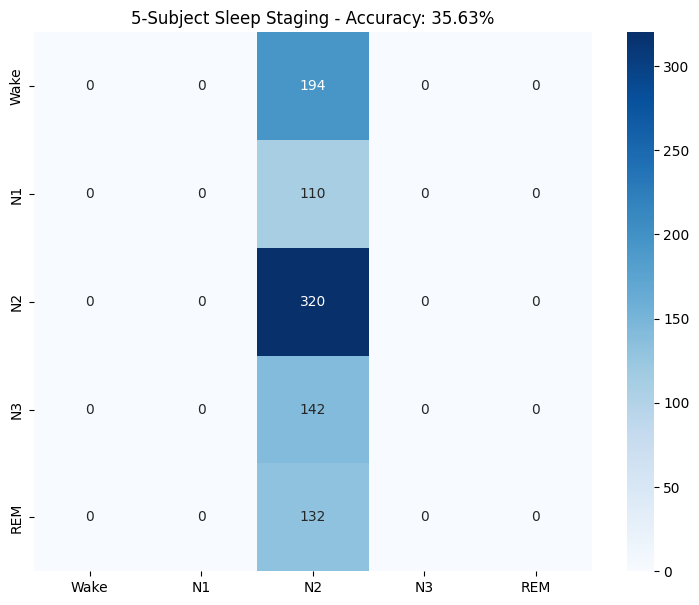

In [31]:
# ------------------- 7. Test + HMM Smoothing -------------------
model.eval()
probs = []
trues = []
with torch.no_grad():
    for x, t in test_loader:
        p = torch.softmax(model(x.to(device)), 1).cpu().numpy()
        probs.append(p)
        trues.append(t.numpy())

probs = np.concatenate(probs)
trues = np.concatenate(trues)
pred = np.argmax(probs, axis=1)

# Simple HMM
trans = np.array([
    [0.95,0.05,0,0,0],
    [0.15,0.60,0.25,0,0],
    [0.05,0.10,0.70,0.10,0.05],
    [0.05,0,0.90,0,0.05],
    [0.10,0,0.80,0,0.10]
])
for i in range(1, len(pred)):
    if trans[pred[i-1], pred[i]] < 0.05:
        pred[i] = np.argmax(probs[i])

acc = accuracy_score(trues, pred)
print(f"\nFINAL ACCURACY (5 คืน): {acc*100:.2f}%")
print(classification_report(trues, pred, target_names=['Wake','N1','N2','N3','REM']))
plt.figure(figsize=(9,7))
sns.heatmap(confusion_matrix(trues, pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Wake','N1','N2','N3','REM'],
            yticklabels=['Wake','N1','N2','N3','REM'])
plt.title(f"5-Subject Sleep Staging - Accuracy: {acc*100:.2f}%")
plt.show()

In [32]:
# ------------------- เช็คว่าคลาสครบทุก set หรือไม่ (สำคัญมาก!) -------------------
from collections import Counter
import numpy as np

def check_class_distribution(y_array, name):
    counts = Counter(y_array)
    print(f"\n{name:>8} → จำนวนทั้งหมด {len(y_array):,} epochs")
    for stage_id in range(5):
        stage_name = ['Wake', 'N1', 'N2', 'N3', 'REM'][stage_id]
        cnt = counts.get(stage_id, 0)
        print(f"   {stage_name:>4}: {cnt:>4} epochs  ({cnt/len(y_array)*100:5.1f}%)", 
              "← หาย!" if cnt == 0 else "")

# ทำการ split ใหม่ให้มี validation set ด้วย (แนะนำ)
from sklearn.model_selection import train_test_split

# แบ่ง Train 80% + (Test+Val) 20%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# จาก 20% นั้น แบ่งเป็น Test 10% + Val 10%
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print("="*70)
check_class_distribution(y_train, "TRAIN")
check_class_distribution(y_val,   "VALIDATION")
check_class_distribution(y_test,  "TEST")
print("="*70)




   TRAIN → จำนวนทั้งหมด 3,591 epochs
   Wake:  775 epochs  ( 21.6%) 
     N1:  441 epochs  ( 12.3%) 
     N2: 1278 epochs  ( 35.6%) 
     N3:  570 epochs  ( 15.9%) 
    REM:  527 epochs  ( 14.7%) 

VALIDATION → จำนวนทั้งหมด 449 epochs
   Wake:   97 epochs  ( 21.6%) 
     N1:   55 epochs  ( 12.2%) 
     N2:  160 epochs  ( 35.6%) 
     N3:   71 epochs  ( 15.8%) 
    REM:   66 epochs  ( 14.7%) 

    TEST → จำนวนทั้งหมด 449 epochs
   Wake:   97 epochs  ( 21.6%) 
     N1:   55 epochs  ( 12.2%) 
     N2:  160 epochs  ( 35.6%) 
     N3:   71 epochs  ( 15.8%) 
    REM:   66 epochs  ( 14.7%) 
